In [0]:
!pip install --no-cache-dir --upgrade scikit-learn


    100% |████████████████████████████████| 5.4MB 2.6MB/s 
  Found existing installation: scikit-learn 0.19.2
    Uninstalling scikit-learn-0.19.2:
      Successfully uninstalled scikit-learn-0.19.2


In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive/AML Task4"

In [0]:
# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.ensemble import GradientBoostingClassifier

In [0]:
TEST_SIZE=0.2
RANDOM_STATE=5
GRID=0
NB_ESTIMATORS=1000

In [0]:
x_data.shape

(10310, 2500)

In [0]:
 #get_scores(reg, x_train, y_train, x_test[1:,:], y_test)
#get_plot(reg, y_test, x_test)
print(y_test)




In [0]:
    print('Extracting\n')
    x_data, y_data, x_out, indexes = getData()
    #x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    x_train=x_data[0:8000,:]
    y_train=y_data[0:8000]
    x_test=x_data[8000:,:]
    y_test=y_data[8000:]
    
    x_train,  x_test, x_out = preprocess_data(x_train, y_train, x_test, x_out)
    print('Training\n')
    reg = fitdata(x_train, y_train)
    get_scores(reg, x_train, y_train, x_test, y_test)
    #predict_output(reg,x_out, indexes)
    print('plotting')
    get_plot(reg, y_test, x_test)


In [0]:
def getData():

 
    #Input file names
    x_file="/content/drive/My Drive/AML Task5/features_train_flow_all2.csv"
    y_file="/content/drive/My Drive/AML Task5/targets_all_flow.csv"
    x_test_file="/content/drive/My Drive/AML Task5/features_test_flow_all2.csv"
    #Import csv files as data frames
    #Extract, from the data frames, the 2D arrays of values
    df0 = pd.read_csv(x_file, header=None)
    df1 = pd.read_csv(y_file, header=None)
    df2 = pd.read_csv(x_test_file, header=None)

    ind = range(69)


    # Extract, from the data frames, the 2D arrays of values
    x_train = df0.values
    x_test = df2.values
    y_train = df1.values[:, 1]

    return x_train, y_train, x_test, ind


def preprocess_data(x_train, y_train, x_test, x_out):

    if 1:
        x_train = preprocessing.scale(x_train)
        x_out = preprocessing.scale(x_out)
        x_test=preprocessing.scale(x_test)

    return x_train, x_test, x_out
def fitdata(x_train, y_train,):
    # Fit a Regression model to the data
    reg = GradientBoostingClassifier(loss='exponential',n_estimators=NB_ESTIMATORS, verbose=1)
    if GRID:
        grid_params=[{'n_estimators': [10,15, 20, 25, 30], 'loss': ['exponential']},
                     {'n_estimators': [10, 15, 20, 25, 30], 'loss': ['deviance']}]
                        #{'C': [0.8, 0.9, 1, 1.1, 1.2, 1.4], 'kernel': ['rbf']}
                        #{'C': [0.4, 0.45, 0.5, 0.55, 0.6, 0.65], 'kernel': ['sigmoid'], 'decision_function_shape':['ovo']},
                        #{'C': [ 0.8, 0.825, 0.85, 0.875, 0.9, 0.925], 'kernel': ['rbf'],'decision_function_shape': ['ovo']},
        grid = GridSearchCV(reg, grid_params, scoring='roc_auc_score', cv=5, verbose=1, n_jobs=-1)
        reg = grid.fit(x_train, y_train).best_estimator_

        print("Best parameters set found on development set:")
        print()
        print(grid.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = grid.cv_results_['mean_test_score']
        stds = grid.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, grid.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()
    else:
        reg= GradientBoostingClassifier(n_estimators=NB_ESTIMATORS, verbose=1, loss='deviance')
        reg.fit(x_train,y_train)
    return reg

def get_scores(reg, x_train, y_train, x_test, y_test):
    # calculate test score
    y_pred = reg.predict_proba(x_test)[:,1]
    y_pred_train = reg.predict_proba(x_train)[:,1]
    test_score = roc_auc_score(y_test, y_pred)
    train_score = roc_auc_score(y_train, y_pred_train)
    print("Test score= %s\n", test_score)
    print("train score= %s", train_score)

def predict_output(reg, x_out, indexes):
    #Output CSV file
    forecast_set=np.matrix(reg.predict_proba(x_out)[:,1]).T
    dd=np.insert(forecast_set,0,indexes,axis=1)
    df=pd.DataFrame(dd)
    df.to_csv('/content/drive/My Drive/AML Task4/forecast.csv',sep=',',float_format='%s',index=False, header=['id','y'])
    return


def get_plot(reg, y_test, x_test):
    # compute test set deviance
    test_score = np.zeros((NB_ESTIMATORS,), dtype=np.float64)

    for i, y_pred in enumerate(reg.staged_decision_function(x_test)):
        test_score[i] =roc_auc_score(y_test, y_pred) #f1_score(y_test, y_pred)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Deviance')
    # plt.plot(np.arange(NB_ESTIMATORS) + 1, reg.train_score_, 'b-',
    #          label='Training Set Deviance')
    plt.plot(np.arange(NB_ESTIMATORS)  + 1, test_score, 'r-',
             label='Test Set Deviance')
    plt.legend(loc='upper right')
    plt.xlabel('Boosting Iterations')
    plt.ylabel('Deviance')

    # #############################################################################
    # Plot feature importance
    feature_importance = reg.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    # sorted_idx = np.argsort(feature_importance)
    # pos = np.arange(sorted_idx.shape[0]) + .5
    pos=np.arange(feature_importance.shape[0]) + .5
    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance, align='center')
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()


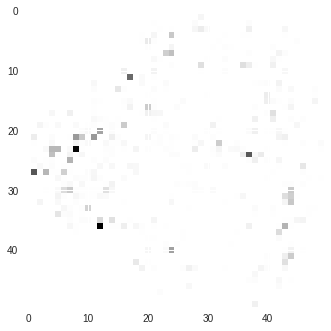

In [0]:
a=reg.feature_importances_
a=a.reshape(50,50)
plt.imshow(a)

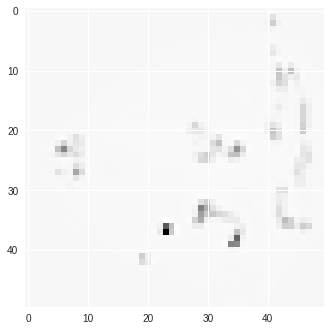

In [0]:
im=x_train[23,:].reshape(50,50)
im=im
plt.imshow(im)

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [0]:
    print('Extracting\n')
    x_data, y_data, x_out, indexes = getData()
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    x_train,  x_test, x_out = preprocess_data(x_train, y_train, x_test, x_out)
    print('Training\n')
    reg = fitdata(x_train, y_train)
    get_scores(reg, x_train, y_train, x_test, y_test)
    predict_output(reg,x_out, indexes)
    get_plot(reg, y_test, x_test)
    reg = fitdata(x_data, y_data, )
    predict_output(reg, x_out, indexes)